In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, min, max, mean, median, stddev
from pyspark.sql.functions import when, concat, lit

In [2]:
spark = SparkSession.builder.appName("DS504ProjectPitches").getOrCreate()

In [3]:
# importing the pitches data
pitches = spark.read.csv("pitches.csv", header=True)
count = pitches.count()
print(count)

2867154


In [4]:
pitches = pitches.fillna({"pitch_type": "Unkown"})

In [16]:
pitch_type = pitches.groupby("pitch_type").count()
pitch_type.show(40)

+----------+-------+
|pitch_type|  count|
+----------+-------+
|        FT| 337983|
|        SC|    113|
|        SL| 450578|
|        FC| 149756|
|        EP|    815|
|        FF|1014877|
|        FS|  43705|
|        PO|    628|
|        KC|  66484|
|        IN|   6197|
|        CH| 292789|
|    Unkown|  14189|
|        CU| 234391|
|        FO|    810|
|        AB|      9|
|        UN|     57|
|        KN|  11260|
|        FA|      9|
|        SI| 242504|
+----------+-------+



In [133]:
pitches_cleaned = pitches.filter(pitches.pitch_type != "FA")
pitches_cleaned = pitches_cleaned.filter(pitches.pitch_type != "AB")
unknown_pitch = (col("pitch_type") == "Unkown")
pitchout_pitch = (col("pitch_type") == "FO")
pitches_cleaned = pitches_cleaned.withColumn("pitch_type", when(unknown_pitch, "UN").when(pitchout_pitch, "PO").otherwise(col("pitch_type")))

In [134]:
pitch_type_cleaned = pitches_cleaned.groupby("pitch_type").count()
pitch_type_cleaned.show(40)

+----------+-------+
|pitch_type|  count|
+----------+-------+
|        FT| 337983|
|        SC|    113|
|        SL| 450578|
|        FC| 149756|
|        EP|    815|
|        FF|1014877|
|        FS|  43705|
|        PO|   1438|
|        KC|  66484|
|        IN|   6197|
|        CH| 292789|
|        CU| 234391|
|        UN|  14246|
|        KN|  11260|
|        SI| 242504|
+----------+-------+



In [123]:
pitch_type_df = pitch_type_cleaned.toPandas()

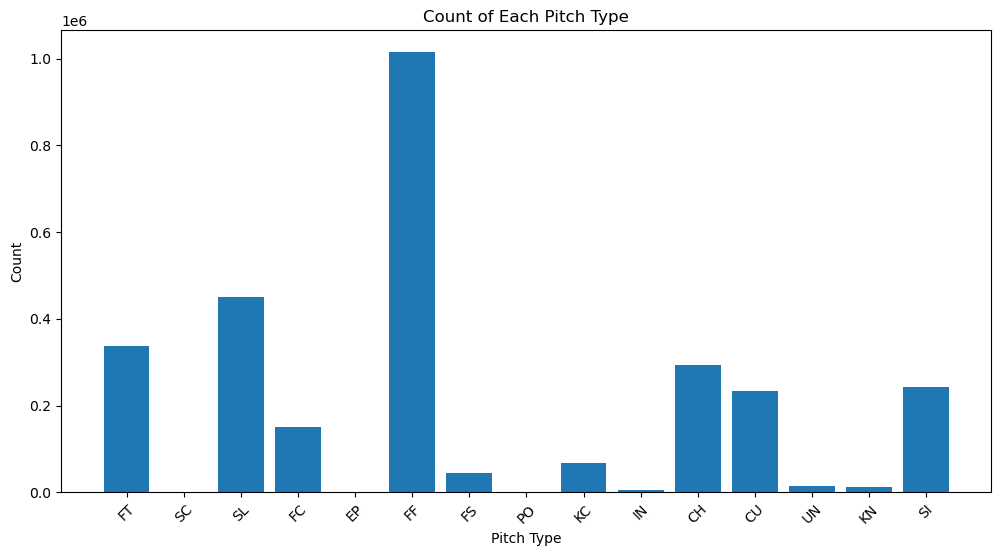

In [124]:
plt.figure(figsize=(12, 6))
plt.bar(pitch_type_df["pitch_type"], pitch_type_df["count"])
plt.xlabel("Pitch Type")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Count of Each Pitch Type")
plt.show()

In [31]:
type = pitches_cleaned.groupby("type").count()
type.show()

+----+-------+
|type|  count|
+----+-------+
|   B|1045117|
|   X| 513163|
|   S|1308865|
+----+-------+



In [32]:
ball_condition = (col("type") == "B")
ball_in_play_condition = (col("type") == "X")
strike_condition = (col("type") == "S")
pitches_feat_eng = pitches_cleaned.withColumn("pitch_outcome", when(ball_condition, 1).when(ball_in_play_condition, 2).when(strike_condition, 3)
                                      )
pitch_outcome_type = pitches_feat_eng.groupby("pitch_outcome").count()
pitch_outcome_type.show()

+-------------+-------+
|pitch_outcome|  count|
+-------------+-------+
|            1|1045117|
|            3|1308865|
|            2| 513163|
+-------------+-------+



In [33]:
pitch_outcome_type_df = pitch_outcome_type.toPandas()

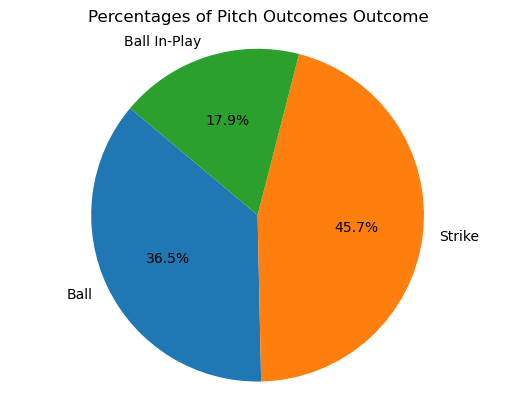

In [34]:
custom_labels = ["Ball", "Strike", "Ball In-Play"]
plt.pie(pitch_outcome_type_df["count"], labels= custom_labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("Percentages of Pitch Outcomes Outcome")
plt.show()

In [135]:
selected_cols = ["px", "pz", "type", "pitch_type", "b_count", "s_count", "outs"]
sel_col_df = pitches_cleaned.select(*selected_cols)
sel_col_df.show()

+------+-----+----+----------+-------+-------+----+
|    px|   pz|type|pitch_type|b_count|s_count|outs|
+------+-----+----+----------+-------+-------+----+
| 0.416|2.963|   S|        FF|    0.0|    0.0| 0.0|
|-0.191|2.347|   S|        FF|    0.0|    1.0| 0.0|
|-0.518|3.284|   S|        FF|    0.0|    2.0| 0.0|
|-0.641|1.221|   B|        FF|    0.0|    2.0| 0.0|
|-1.821|2.083|   B|        CU|    1.0|    2.0| 0.0|
| 0.627|2.397|   X|        FF|    2.0|    2.0| 0.0|
|-1.088| 1.61|   B|        FF|    0.0|    0.0| 1.0|
|-0.257|2.047|   X|        FC|    1.0|    0.0| 1.0|
|  1.47| 2.35|   B|        FF|    0.0|    0.0| 1.0|
|-1.337|1.898|   B|        FF|    1.0|    0.0| 1.0|
|-0.286| 1.83|   X|        FF|    2.0|    0.0| 1.0|
|   0.2|2.643|   S|        SI|    0.0|    0.0| 1.0|
|-0.741| 2.93|   S|        FF|    0.0|    1.0| 1.0|
|-0.711|1.971|   S|        CU|    0.0|    2.0| 1.0|
|-1.539|1.525|   B|        FF|    0.0|    0.0| 2.0|
|-0.881|1.888|   S|        FF|    1.0|    0.0| 2.0|
| 0.096|2.79

In [136]:
sel_pitch = sel_col_df.toPandas()
sel_pitch['px'] = sel_pitch['px'].astype(float)
sel_pitch['pz'] = sel_pitch['pz'].astype(float)

Py4JJavaError: An error occurred while calling o398.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [115]:
strike_zone_x = (-0.71, -0.71, 0.71, 0.71, -0.71)
strike_zone_y = (1.6, 3.4, 3.4, 1.6, 1.6)

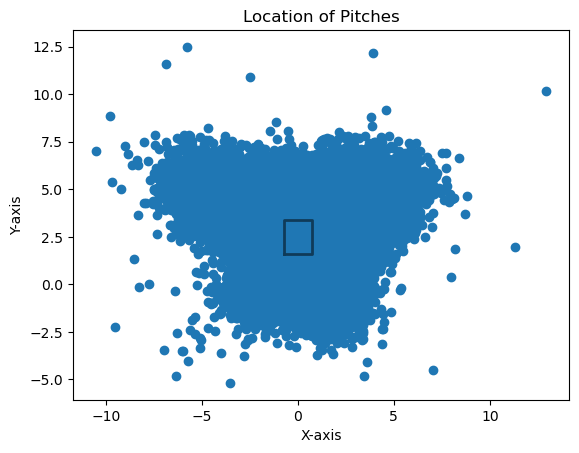

In [116]:
plt.scatter(sel_pitch['px'],sel_pitch['pz'])
plt.plot(strike_zone_x, strike_zone_y, color='black', linewidth = 2, alpha = .5)
plt.title("Location of Pitches")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [117]:
import seaborn as sns

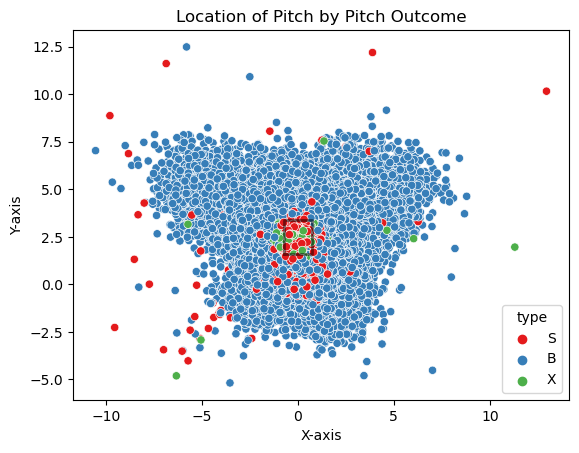

In [118]:
color_palette = sns.color_palette("Set1", n_colors=len(sel_pitch['type'].unique()))
custom_labels = ["Ball", "Strike", "Ball In-Play"]
sns.scatterplot(x=sel_pitch['px'], y= sel_pitch['pz'], hue = sel_pitch['type'], palette=color_palette)
plt.plot(strike_zone_x, strike_zone_y, color='black', linewidth = 2, alpha = .5)
plt.title("Location of Pitch by Pitch Outcome")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

C:\Users\camer\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


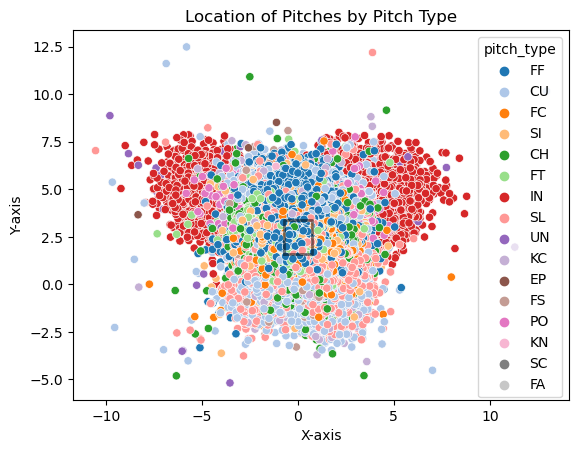

In [127]:
color_palette = sns.color_palette("tab20", n_colors=len(sel_pitch['pitch_type'].unique()))
sns.scatterplot(x=sel_pitch['px'], y= sel_pitch['pz'], hue = sel_pitch['pitch_type'], palette=color_palette)
plt.plot(strike_zone_x, strike_zone_y, color='black', linewidth = 2, alpha = .5)
plt.title("Location of Pitches by Pitch Type")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [129]:
color_palette = sns.color_palette("tab20", n_colors=len(sel_pitch['pitch_type'].unique()))
sns.scatterplot(x=sel_pitch['px'], y= sel_pitch['pz'], hue = sel_pitch['pitch_type'], style=sel_pitch['type'], palette=color_palette)
plt.plot(strike_zone_x, strike_zone_y, color='black', linewidth = 2, alpha = .5)
plt.title("Location of Pitches by Pitch Type and Outcome")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

KeyboardInterrupt: 

In [137]:
strike_data = sel_pitch.where(sel_pitch['type'] == 'S')
strike_data.dropna()

,px,pz,type,pitch_type,b_count,s_count,outs
0,0.416000,2.963000,S,FF,0.0,0.0,0.0
1,-0.191000,2.347000,S,FF,0.0,1.0,0.0
2,-0.518000,3.284000,S,FF,0.0,2.0,0.0
11,0.200000,2.643000,S,SI,0.0,0.0,1.0
12,-0.741000,2.930000,S,FF,0.0,1.0,1.0
...,...,...,...,...,...,...,...
2867137,-0.599352,1.981704,S,FF,3.0,2.0,2.0
2867138,0.500757,2.783971,S,FF,3.0,2.0,2.0
2867139,0.317585,3.421140,S,FF,3.0,2.0,2.0
2867142,-0.444578,2.619287,S,FF,1.0,0.0,2.0


In [138]:
a = len(strike_data['pitch_type'].unique())
a

16

In [147]:
color_palette = sns.color_palette("tab20", n_colors=15)
sns.scatterplot(x=strike_data['px'], y= strike_data['pz'], hue = strike_data['pitch_type'], palette=color_palette)
plt.plot(strike_zone_x, strike_zone_y, color='black', linewidth = 2, alpha = .5)
plt.title("Strike Location by Pitch Type")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

C:\Users\camer\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

In [148]:
ball_data = sel_pitch.where(sel_pitch['type'] == 'B')
ball_data.dropna()

,px,pz,type,pitch_type,b_count,s_count,outs
3,-0.641000,1.221000,B,FF,0.0,2.0,0.0
4,-1.821000,2.083000,B,CU,1.0,2.0,0.0
6,-1.088000,1.610000,B,FF,0.0,0.0,1.0
8,1.470000,2.350000,B,FF,0.0,0.0,1.0
9,-1.337000,1.898000,B,FF,1.0,0.0,1.0
...,...,...,...,...,...,...,...
2867130,0.676805,3.487355,B,SL,1.0,1.0,1.0
2867132,-0.107080,0.886212,B,SL,0.0,0.0,2.0
2867133,0.239849,1.343620,B,FF,1.0,0.0,2.0
2867134,1.735599,3.282581,B,FF,2.0,0.0,2.0


C:\Users\camer\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


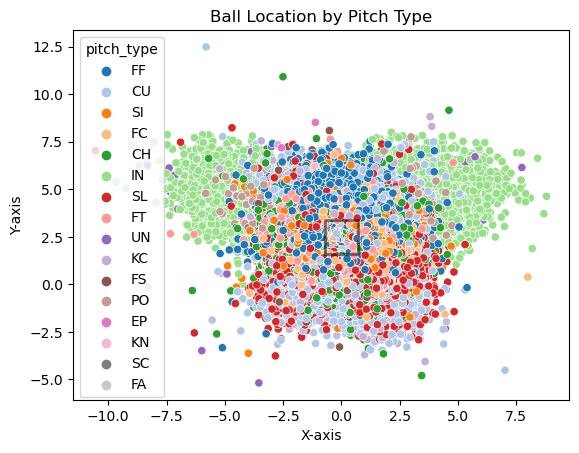

In [153]:
color_palette = sns.color_palette("tab20", n_colors=16)
sns.scatterplot(x=ball_data['px'], y= ball_data['pz'], hue = ball_data['pitch_type'], palette=color_palette)
plt.plot(strike_zone_x, strike_zone_y, color='black', linewidth = 2, alpha = .5)
plt.title("Ball Location by Pitch Type")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [143]:
b = len(ball_data['pitch_type'].unique())
b

17

In [154]:
bip_data = sel_pitch.where(sel_pitch['type'] == 'X')
bip_data.dropna()

,px,pz,type,pitch_type,b_count,s_count,outs
5,0.627000,2.397000,X,FF,2.0,2.0,0.0
7,-0.257000,2.047000,X,FC,1.0,0.0,1.0
10,-0.286000,1.830000,X,FF,2.0,0.0,1.0
20,0.008000,2.602000,X,FC,1.0,0.0,0.0
24,0.788000,1.808000,X,FC,1.0,2.0,0.0
...,...,...,...,...,...,...,...
2867120,-1.113722,2.707495,X,FF,1.0,1.0,2.0
2867123,-0.212890,1.587859,X,SL,1.0,1.0,2.0
2867131,-0.276509,2.623196,X,FF,2.0,1.0,1.0
2867140,0.230280,1.784910,X,SL,3.0,2.0,2.0


C:\Users\camer\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


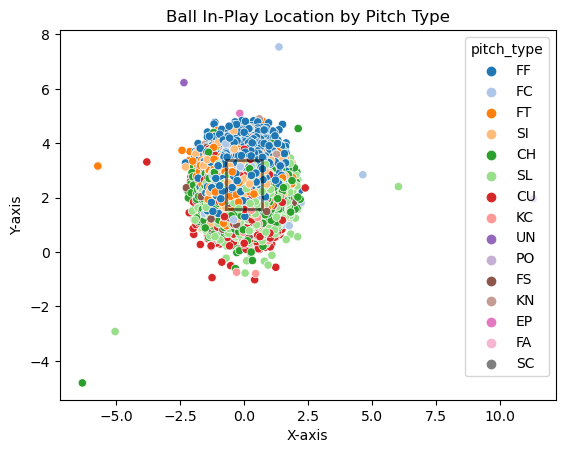

In [156]:
c = len(bip_data['pitch_type'].unique())
color_palette = sns.color_palette("tab20", n_colors=c-1)
sns.scatterplot(x=bip_data['px'], y= bip_data['pz'], hue = bip_data['pitch_type'], palette=color_palette)
plt.plot(strike_zone_x, strike_zone_y, color='black', linewidth = 2, alpha = .5)
plt.title("Ball In-Play Location by Pitch Type")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()